In [2]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from google.colab import drive
drive.mount('/content/gdrive')

# We load the reviews dataset
original_reviews = pd.read_csv('/content/gdrive/MyDrive/Machine Learning Project/Musical_instruments_reviews.csv')
reviews = original_reviews.copy()
print ("The shape of the  data is (row, column):"+ str(reviews.shape))
print (reviews.info())
reviews.head()

Mounted at /content/gdrive
The shape of the  data is (row, column):(10261, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB
None


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [3]:
# We do preprocessing and cleaning of the data.

# We check null values in the reviews dataset.
reviews.isnull().sum()

# We drop de unnecessary columns: reviewerName, unixReviewTime, reviewerID, and asin.
reviews=reviews.drop(['reviewerName','unixReviewTime','reviewerID','asin'], axis=1)
# We combine reviews text and summary to do sentiment analysis on both together.
# We need to consider also null reviews text since those missing test may have a summary, in those cases we only include the summary for sentiment analysis.
reviews['reviewText']=reviews['reviewText'].fillna('')
reviews['finalreviews']=reviews['reviewText']+' '+reviews['summary']
reviews=reviews.drop(['reviewText', 'summary'], axis=1)

# We create the sentiment column with values: positive, negative, and neutral
# Positive are reviews with 5.0 or 4.0 overall
# Neutral are reviews with 3.0 overall
# Negative are reviews with 2.0 or 1.0 overall
# This field will be the target feature when training
reviews['overall'].value_counts()
reviews['sentiment'] = ''
for i in range(len(reviews['overall'])):
  if reviews['overall'][i] == 5.0 or reviews['overall'][i] == 4.0:
    reviews['sentiment'][i] = 'positive'
  elif reviews['overall'][i] == 3.0:
    reviews['sentiment'][i] = 'neutral'
  elif reviews['overall'][i] == 2.0 or reviews['overall'][i] == 1.0:
    reviews['sentiment'][i] = 'negative'

# We modify helpful column to be easily understandable for machine learning analysis
# Now helpful column returns a rate that is a/b being a the people that found the review helpful and b the total number of people that rated the helpfulness

help1 = reviews["helpful"].str.split(",", n = 1, expand = True)
help2 = help1[0].str.split("[", n = 1, expand = True).drop([0], axis=1).astype(str).astype(int)
help3 = help1[1].str.split("]", n = 1, expand = True).drop([1], axis=1).astype(str).astype(int)

helpfinal=pd.concat([help2, help3], axis=1)
helpfinal['finalresult']= helpfinal[1]/helpfinal[0]
helpfinal['finalresult'] = helpfinal['finalresult'].fillna(0)
helpfinal['finalresult'] = helpfinal['finalresult'].round(2)
reviews['helpful']=helpfinal['finalresult']   

# We clean the text making it all lowercase, removing puntuation and text in brackets, removing links...
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

reviews['finalreviews']=reviews['finalreviews'].apply(lambda x:review_cleaning(x))
reviews.head()

<ipython-input-3-b275a4709ab4>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['sentiment'][i] = 'positive'
<ipython-input-3-b275a4709ab4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['sentiment'][i] = 'neutral'
<ipython-input-3-b275a4709ab4>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['sentiment'][i] = 'negative'


,helpful,overall,reviewTime,finalreviews,sentiment
0,0.00,5.0,"02 28, 2014",not much to write about here but it does exact...,positive
1,0.93,5.0,"03 16, 2013",the product does exactly as it should and is q...,positive
2,1.00,5.0,"08 28, 2013",the primary job of this device is to block the...,positive
3,0.00,5.0,"02 14, 2014",nice windscreen protects my mxl mic and preven...,positive
4,0.00,5.0,"02 21, 2014",this pop filter is great it looks and performs...,positive


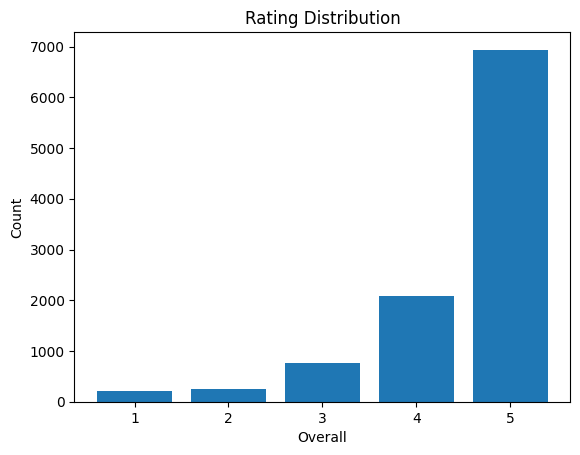

In [4]:
# We do story generation for the reviews showing important plots to be considered before applying the ML models
# Number of ratings by rating category through a barplot
value_counts = Counter(reviews['overall'])

# Convert the counts to two lists: one for values, one for counts
values = list(value_counts.keys())
counts = list(value_counts.values())

# Plot the data as a bar chart
plt.bar(values, counts)

# Add labels and title
plt.xlabel('Overall')
plt.ylabel('Count')
plt.title('Rating Distribution')

# Show the plot
plt.show()

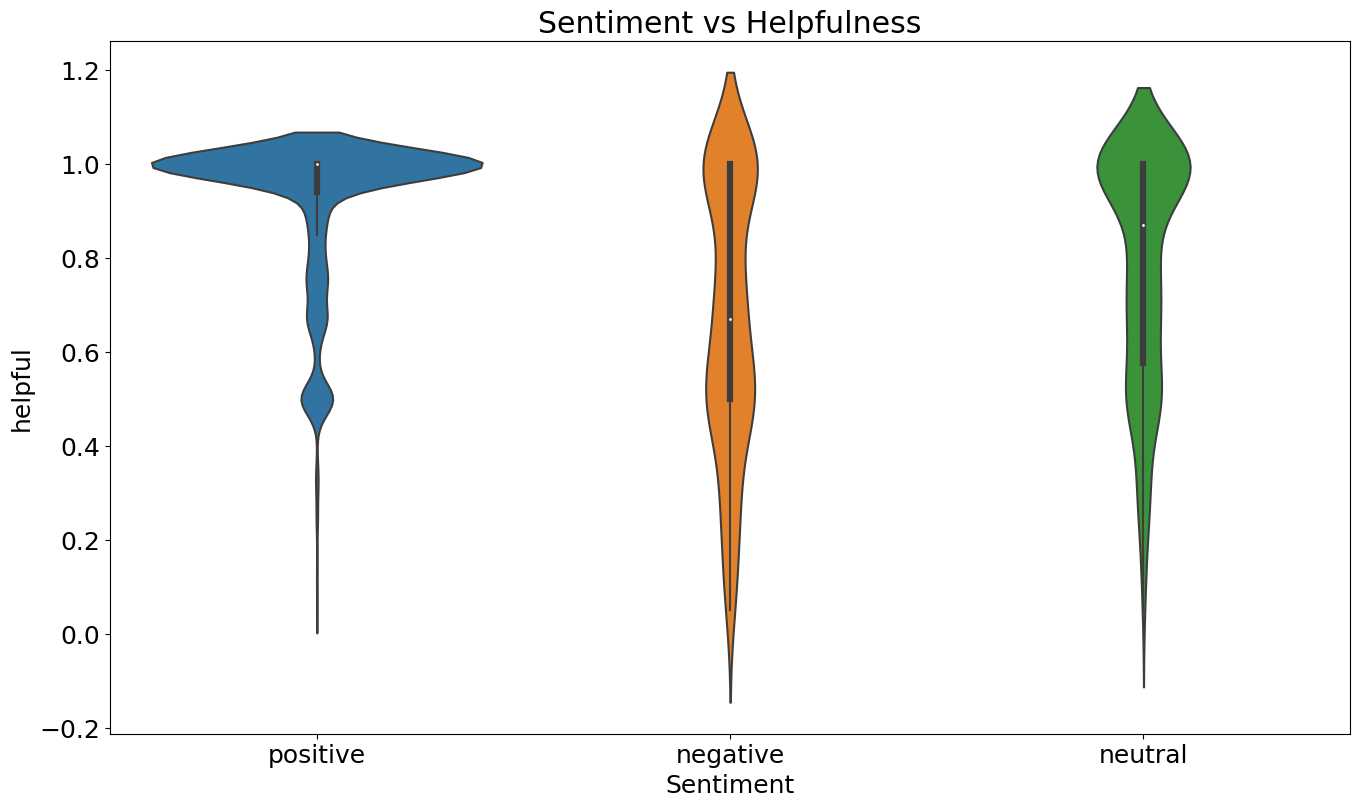

In [5]:
# Sentiments vs Helpfulness throguth a violin plot

plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
sentiment_helpful= pd.DataFrame(reviews, columns = ['sentiment', 'helpful'])
sentiment_helpful = sentiment_helpful[sentiment_helpful['helpful'] != 0.00] 

#Plotting phase
sns.violinplot( x=sentiment_helpful["sentiment"], y=sentiment_helpful["helpful"])
plt.title('Sentiment vs Helpfulness')
plt.xlabel('Sentiment')
plt.ylabel('helpful')
plt.show()

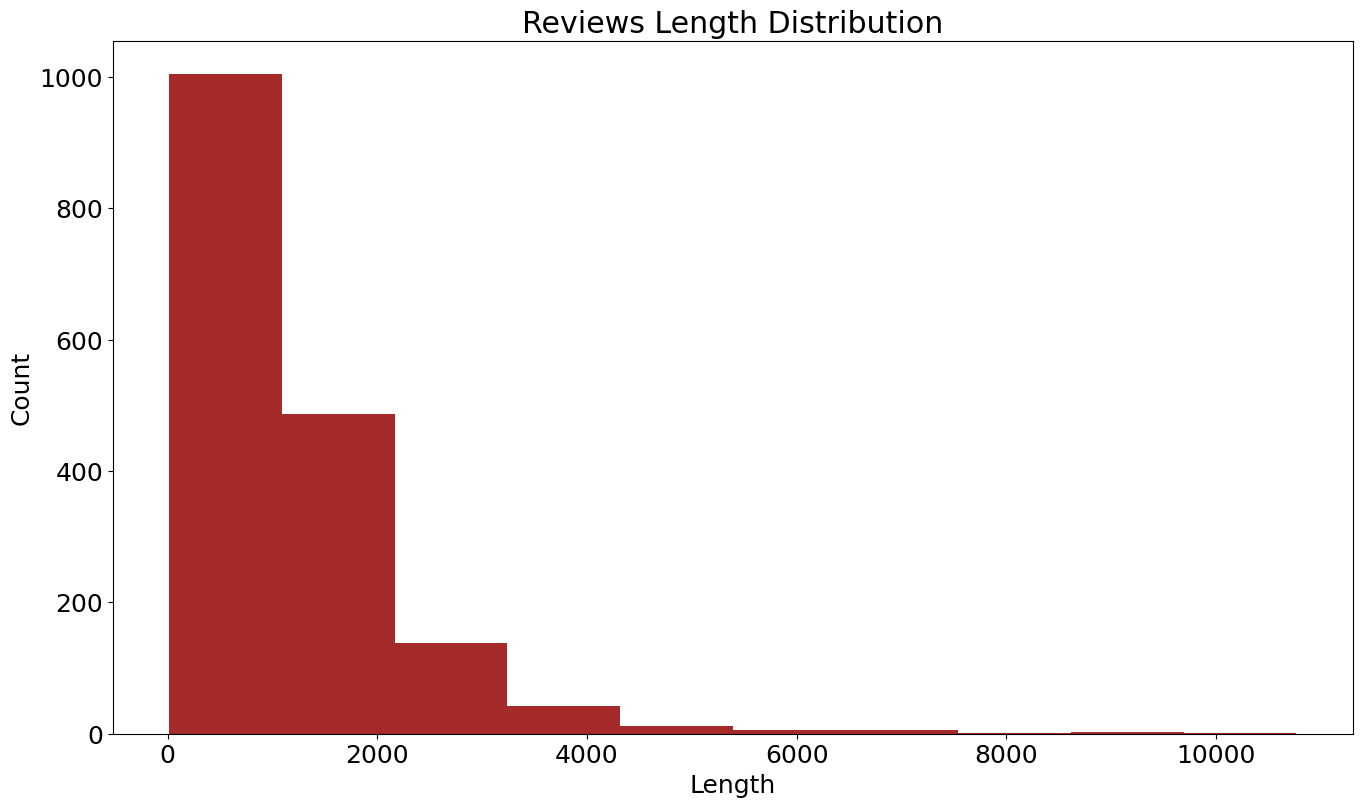

In [6]:
# Review Length Distribution

reviews_len = reviews['finalreviews'].astype(str).apply(len)

value_counts = Counter(reviews_len)

# Convert the counts to two lists: one for values, one for counts
values = list(value_counts.keys())
counts = list(value_counts.values())

# Plot the data as a bar chart
plt.hist(values, color= 'brown')

# Add labels and title
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Reviews Length Distribution')

# Show the plot
plt.show()

Text(0.5, 1.0, 'Trigrams Frequency of negative reviews')

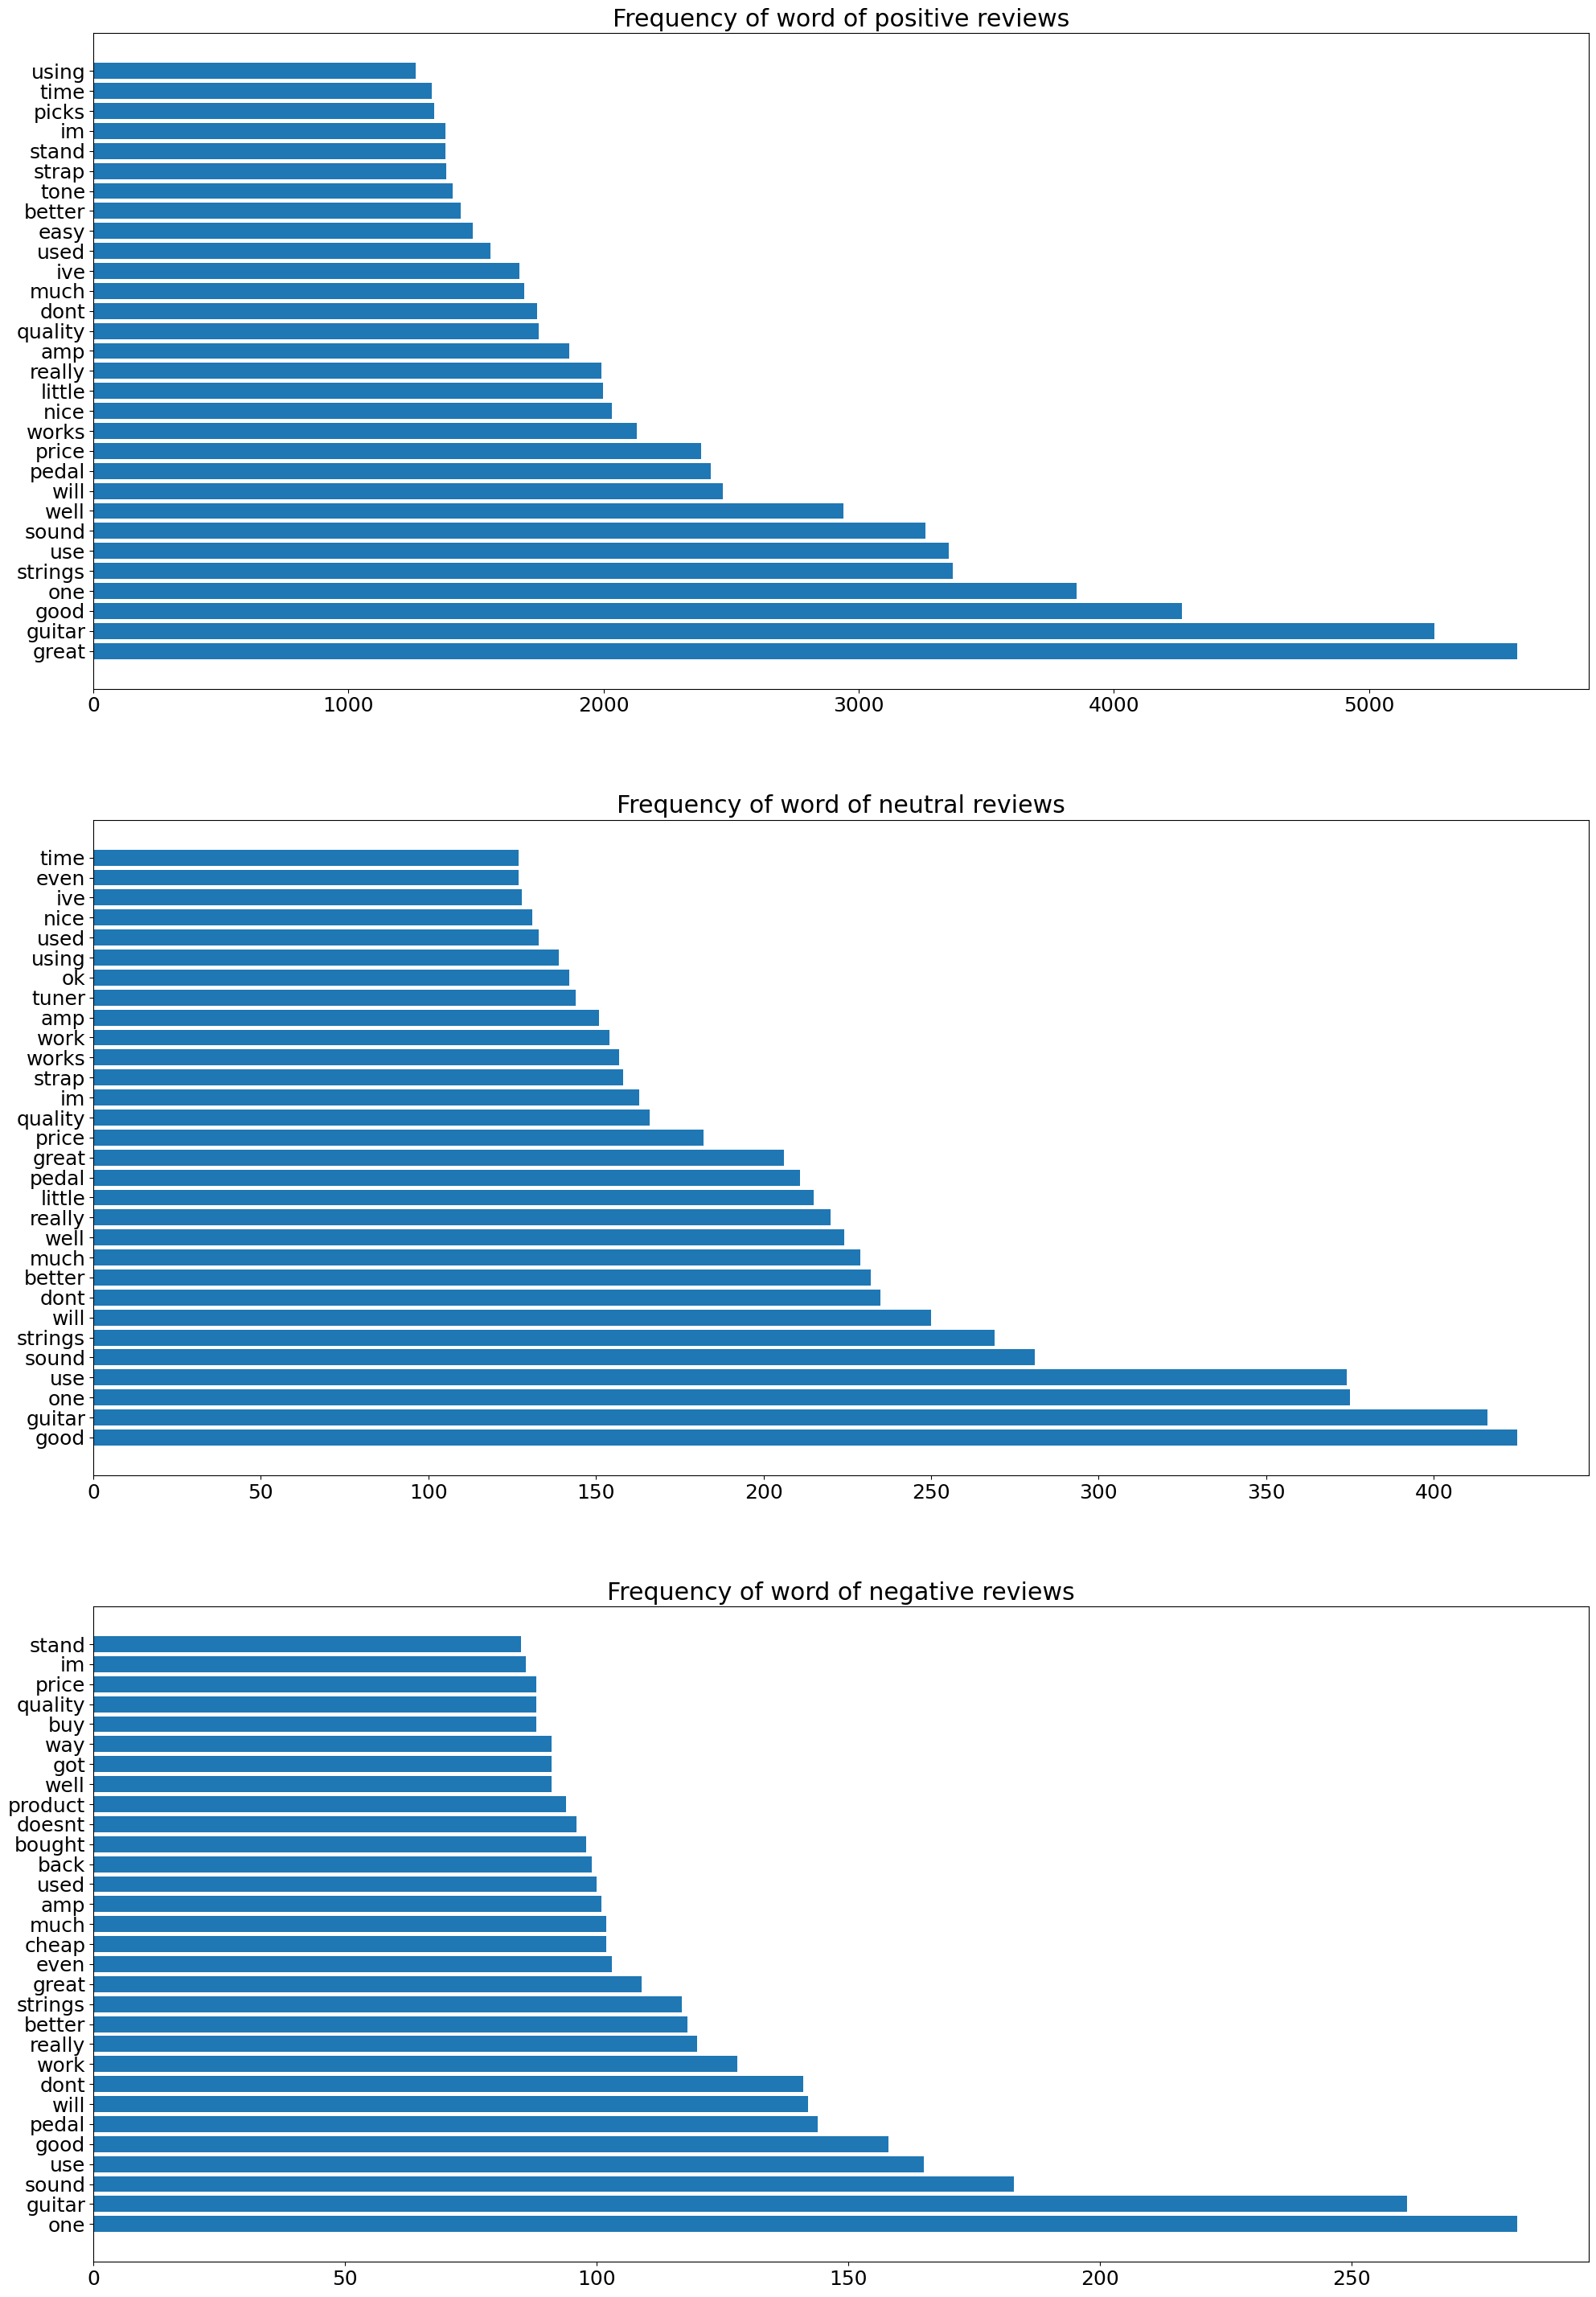

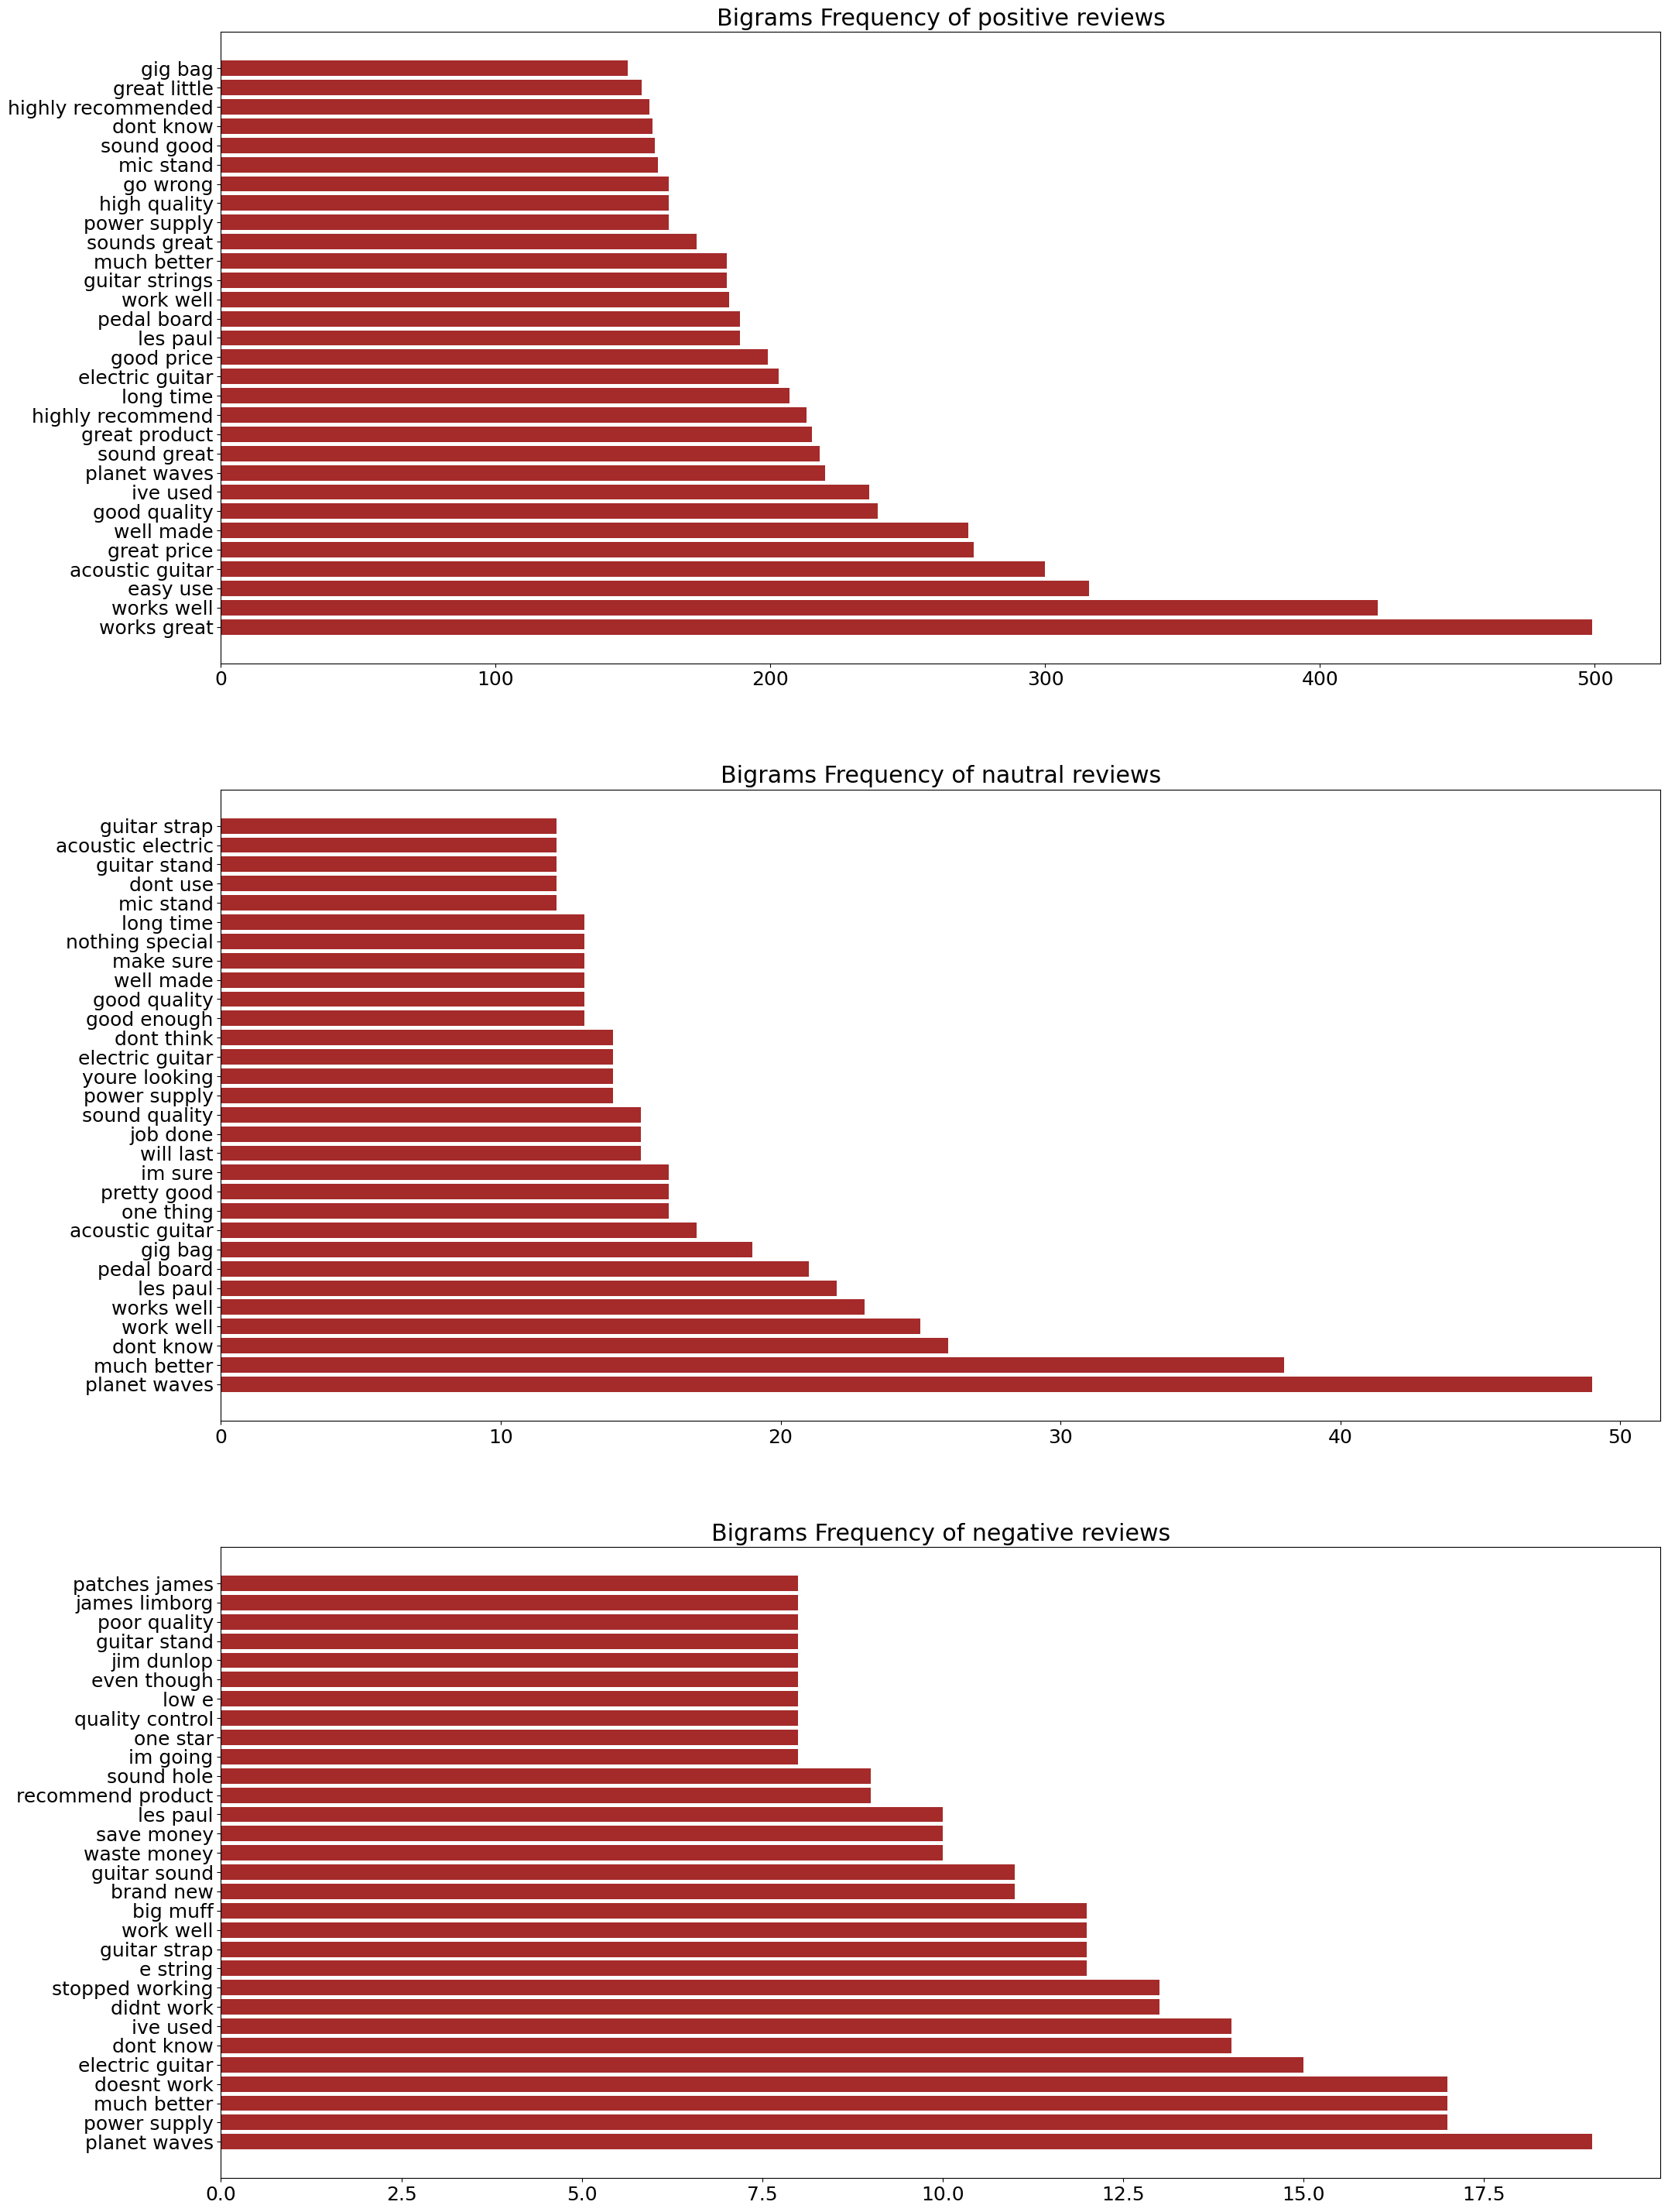

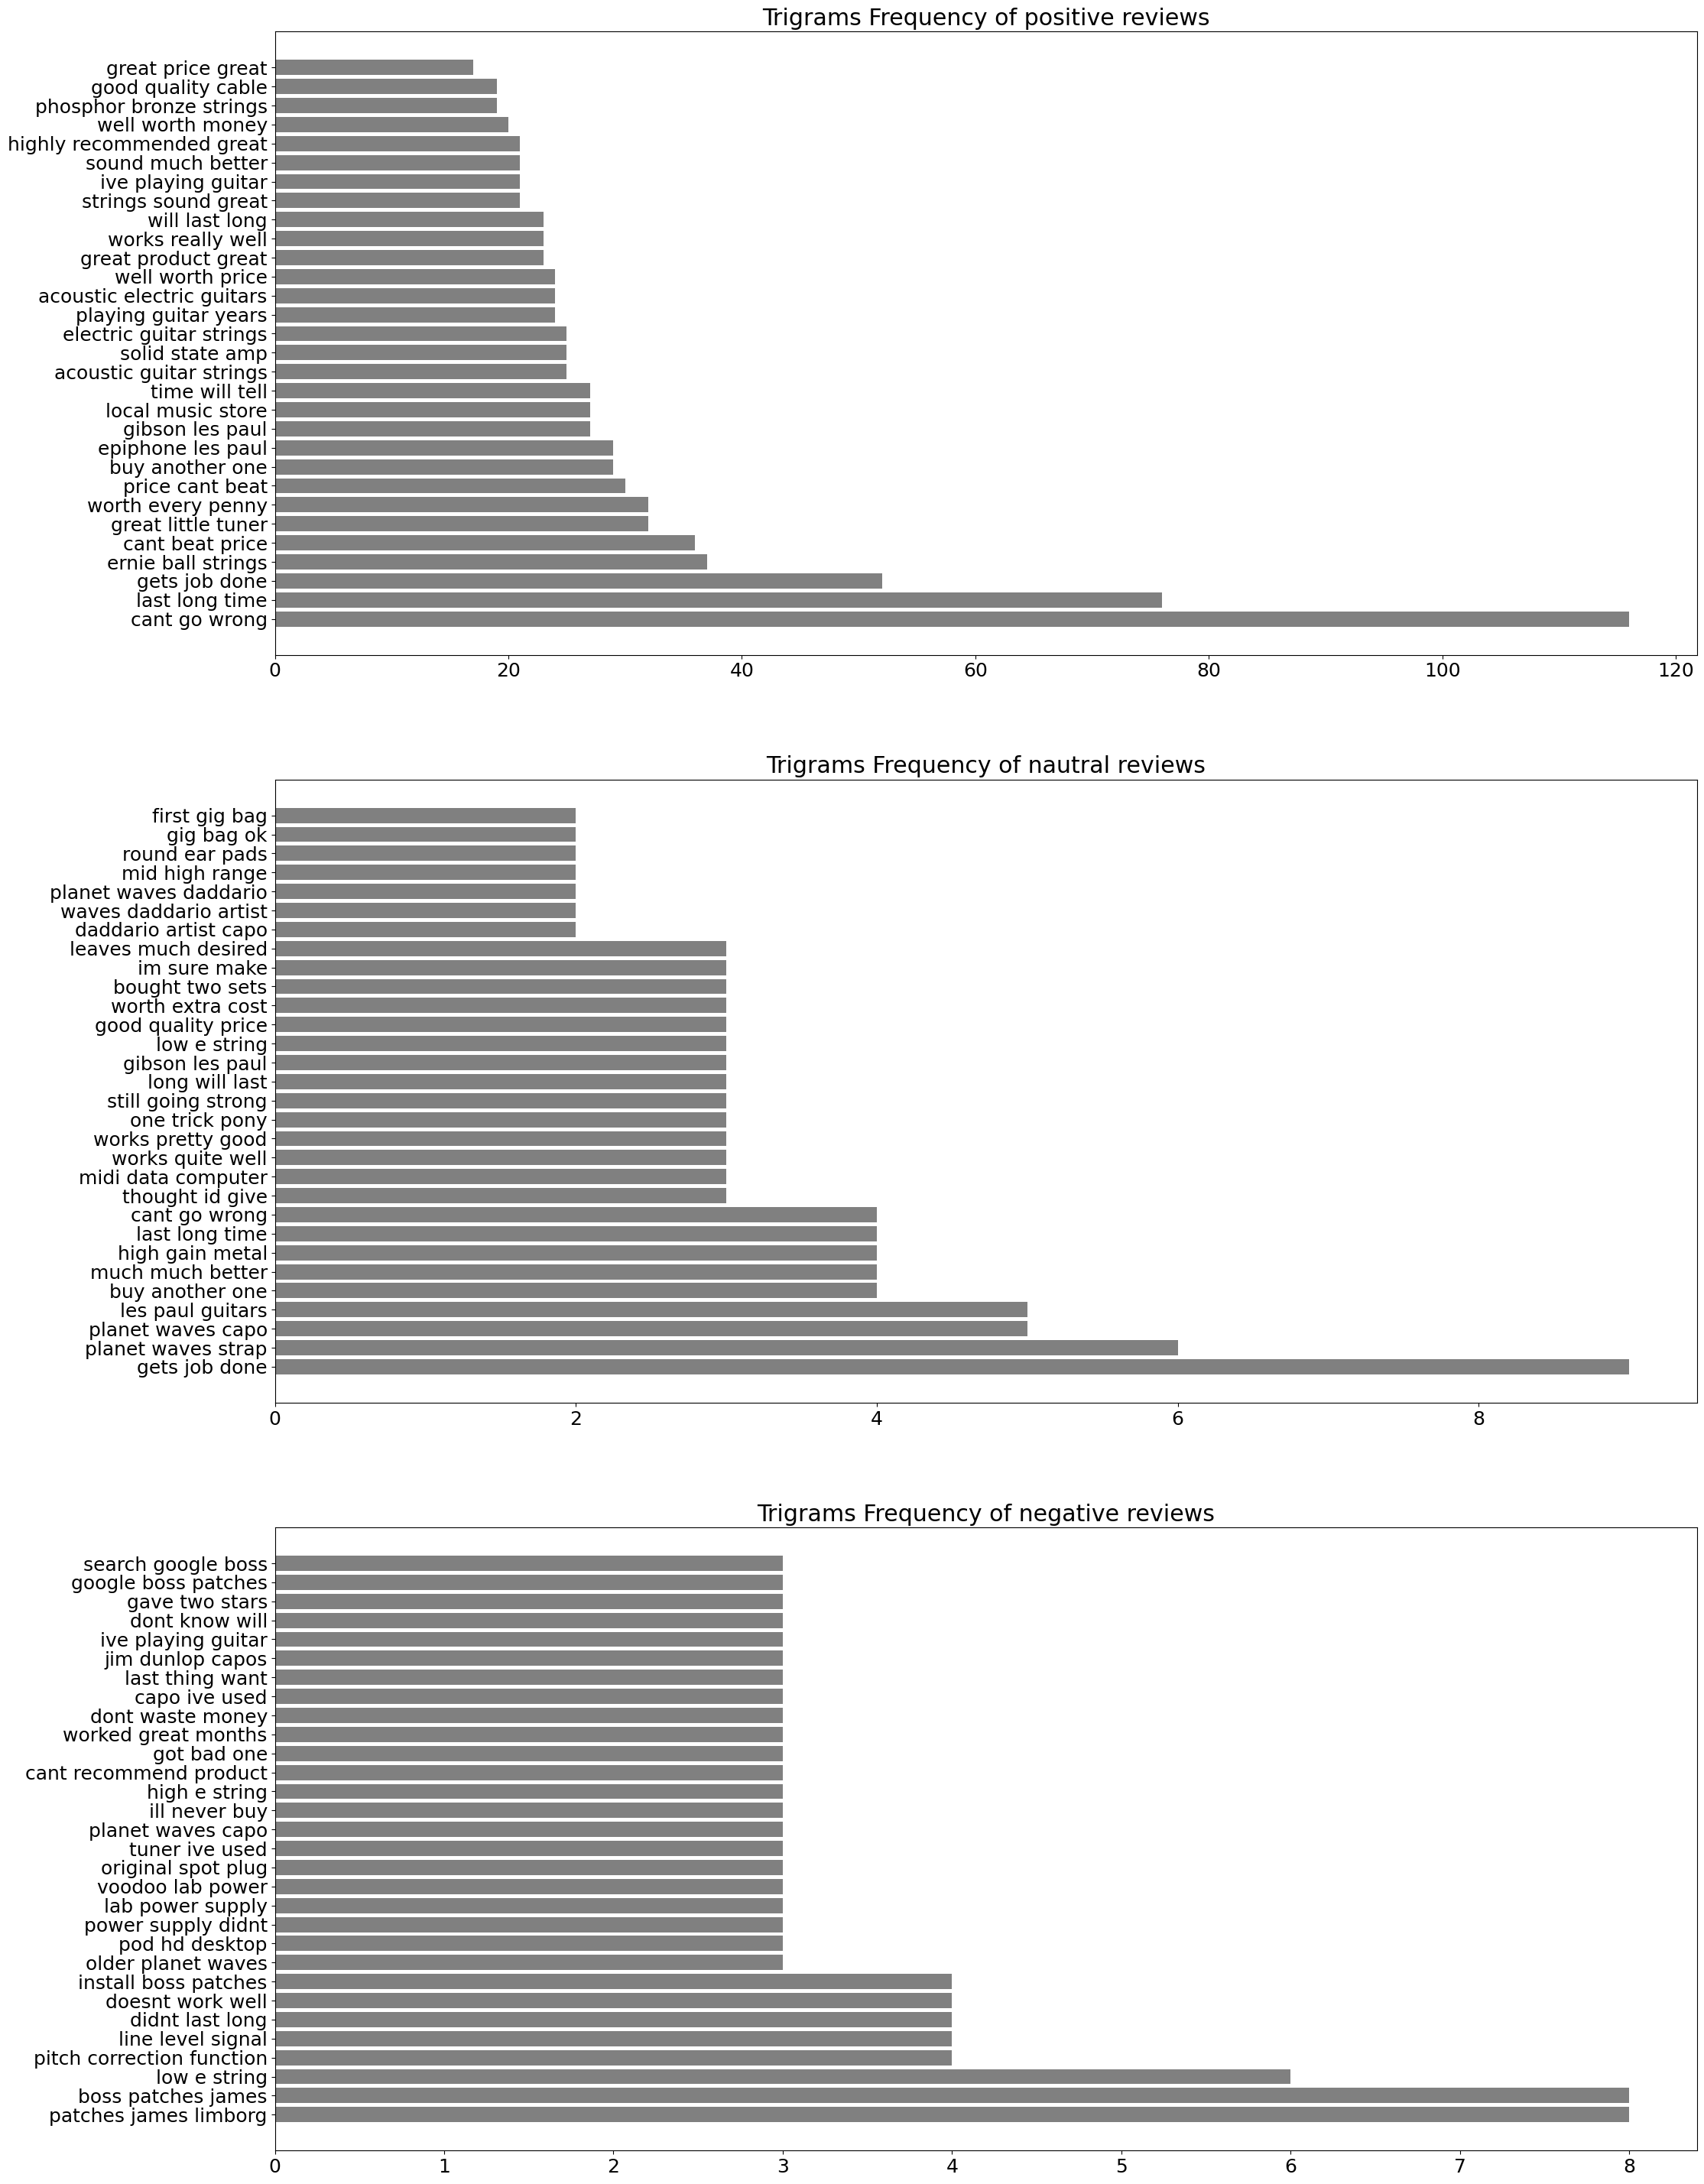

In [7]:
# We do a n-gram analysis considering positive, neutral and negative reviews separately

review_positive = reviews[reviews['sentiment']=='positive'].dropna()
review_neutral = reviews[reviews['sentiment']=='neutral'].dropna()
review_negative =reviews[reviews['sentiment']=='negative'].dropna()

# We build a function that generates ngrams from a given text
def generate_ngrams(text, n=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

# We generate unigrams for positive, negative and neutral reviews and we plot them, from the ngrams we drop the STOPWORDS
# STOPWORDS are words that appear most in the text but does not give us extra information about its sentiment, some STOPWORDS include the, a, and, I, etc...

freq_dict_positive = defaultdict(int)
for texts in review_positive['finalreviews']:
    for words in generate_ngrams(texts):
        freq_dict_positive[words] += 1
fd_sorted_positive = pd.DataFrame(sorted(freq_dict_positive.items(), key=lambda x: x[1])[::-1])
fd_sorted_positive.columns = ['word', 'wordcount']

freq_dict_neutral = defaultdict(int)
for texts in review_neutral['finalreviews']:
    for words in generate_ngrams(texts):
        freq_dict_neutral[words] += 1
fd_sorted_neutral = pd.DataFrame(sorted(freq_dict_neutral.items(), key=lambda x: x[1])[::-1])
fd_sorted_neutral.columns = ['word', 'wordcount']

freq_dict_negative = defaultdict(int)
for texts in review_negative['finalreviews']:
    for words in generate_ngrams(texts):
        freq_dict_negative[words] += 1
fd_sorted_negative = pd.DataFrame(sorted(freq_dict_negative.items(), key=lambda x: x[1])[::-1])
fd_sorted_negative.columns = ['word', 'wordcount']

fig, axs = plt.subplots(3, 1, figsize=(24, 36))

axs[0].barh(fd_sorted_positive['word'].head(30), fd_sorted_positive['wordcount'].head(30))
axs[0].set_title('Frequency of word of positive reviews')

axs[1].barh(fd_sorted_neutral['word'].head(30), fd_sorted_neutral['wordcount'].head(30))
axs[1].set_title('Frequency of word of neutral reviews')

axs[2].barh(fd_sorted_negative['word'].head(30), fd_sorted_negative['wordcount'].head(30))
axs[2].set_title('Frequency of word of negative reviews')

# We generate bigrams for positive, negative and neutral reviews and we plot them, from the ngrams we drop the STOPWORDS

freq_dict_positive_bigrams = defaultdict(int)
for texts in review_positive['finalreviews']:
    for words in generate_ngrams(texts,2):
        freq_dict_positive_bigrams[words] += 1
fd_sorted_positive_bigrams = pd.DataFrame(sorted(freq_dict_positive_bigrams.items(), key=lambda x: x[1])[::-1])
fd_sorted_positive_bigrams.columns = ['word', 'wordcount']

freq_dict_neutral_bigrams = defaultdict(int)
for texts in review_neutral['finalreviews']:
    for words in generate_ngrams(texts,2):
        freq_dict_neutral_bigrams[words] += 1
fd_sorted_neutral_bigrams = pd.DataFrame(sorted(freq_dict_neutral_bigrams.items(), key=lambda x: x[1])[::-1])
fd_sorted_neutral_bigrams.columns = ['word', 'wordcount']

freq_dict_negative_bigrams = defaultdict(int)
for texts in review_negative['finalreviews']:
    for words in generate_ngrams(texts,2):
        freq_dict_negative_bigrams[words] += 1
fd_sorted_negative_bigrams = pd.DataFrame(sorted(freq_dict_negative_bigrams.items(), key=lambda x: x[1])[::-1])
fd_sorted_negative_bigrams.columns = ['word', 'wordcount']

fig, axs = plt.subplots(3, 1, figsize=(24, 36))

axs[0].barh(fd_sorted_positive_bigrams['word'].head(30), fd_sorted_positive_bigrams['wordcount'].head(30), color = 'brown')
axs[0].set_title('Bigrams Frequency of positive reviews')

axs[1].barh(fd_sorted_neutral_bigrams['word'].head(30), fd_sorted_neutral_bigrams['wordcount'].head(30), color = 'brown')
axs[1].set_title('Bigrams Frequency of nautral reviews')

axs[2].barh(fd_sorted_negative_bigrams['word'].head(30), fd_sorted_negative_bigrams['wordcount'].head(30), color = 'brown')
axs[2].set_title('Bigrams Frequency of negative reviews')

# We generate trigrams for positive, negative and neutral reviews and we plot them, from the ngrams we drop the STOPWORDS

freq_dict_positive_trigrams = defaultdict(int)
for texts in review_positive['finalreviews']:
    for words in generate_ngrams(texts,3):
        freq_dict_positive_trigrams[words] += 1
fd_sorted_positive_trigrams = pd.DataFrame(sorted(freq_dict_positive_trigrams.items(), key=lambda x: x[1])[::-1])
fd_sorted_positive_trigrams.columns = ['word', 'wordcount']

freq_dict_neutral_trigrams = defaultdict(int)
for texts in review_neutral['finalreviews']:
    for words in generate_ngrams(texts,3):
        freq_dict_neutral_trigrams[words] += 1
fd_sorted_neutral_trigrams = pd.DataFrame(sorted(freq_dict_neutral_trigrams.items(), key=lambda x: x[1])[::-1])
fd_sorted_neutral_trigrams.columns = ['word', 'wordcount']

freq_dict_negative_trigrams = defaultdict(int)
for texts in review_negative['finalreviews']:
    for words in generate_ngrams(texts,3):
        freq_dict_negative_trigrams[words] += 1
fd_sorted_negative_trigrams = pd.DataFrame(sorted(freq_dict_negative_trigrams.items(), key=lambda x: x[1])[::-1])
fd_sorted_negative_trigrams.columns = ['word', 'wordcount']

fig, axs = plt.subplots(3, 1, figsize=(24, 36))

axs[0].barh(fd_sorted_positive_trigrams['word'].head(30), fd_sorted_positive_trigrams['wordcount'].head(30), color = 'gray')
axs[0].set_title('Trigrams Frequency of positive reviews')

axs[1].barh(fd_sorted_neutral_trigrams['word'].head(30), fd_sorted_neutral_trigrams['wordcount'].head(30), color = 'gray')
axs[1].set_title('Trigrams Frequency of nautral reviews')

axs[2].barh(fd_sorted_negative_trigrams['word'].head(30), fd_sorted_negative_trigrams['wordcount'].head(30), color = 'gray')
axs[2].set_title('Trigrams Frequency of negative reviews')

(-0.5, 2999.5, 1999.5, -0.5)

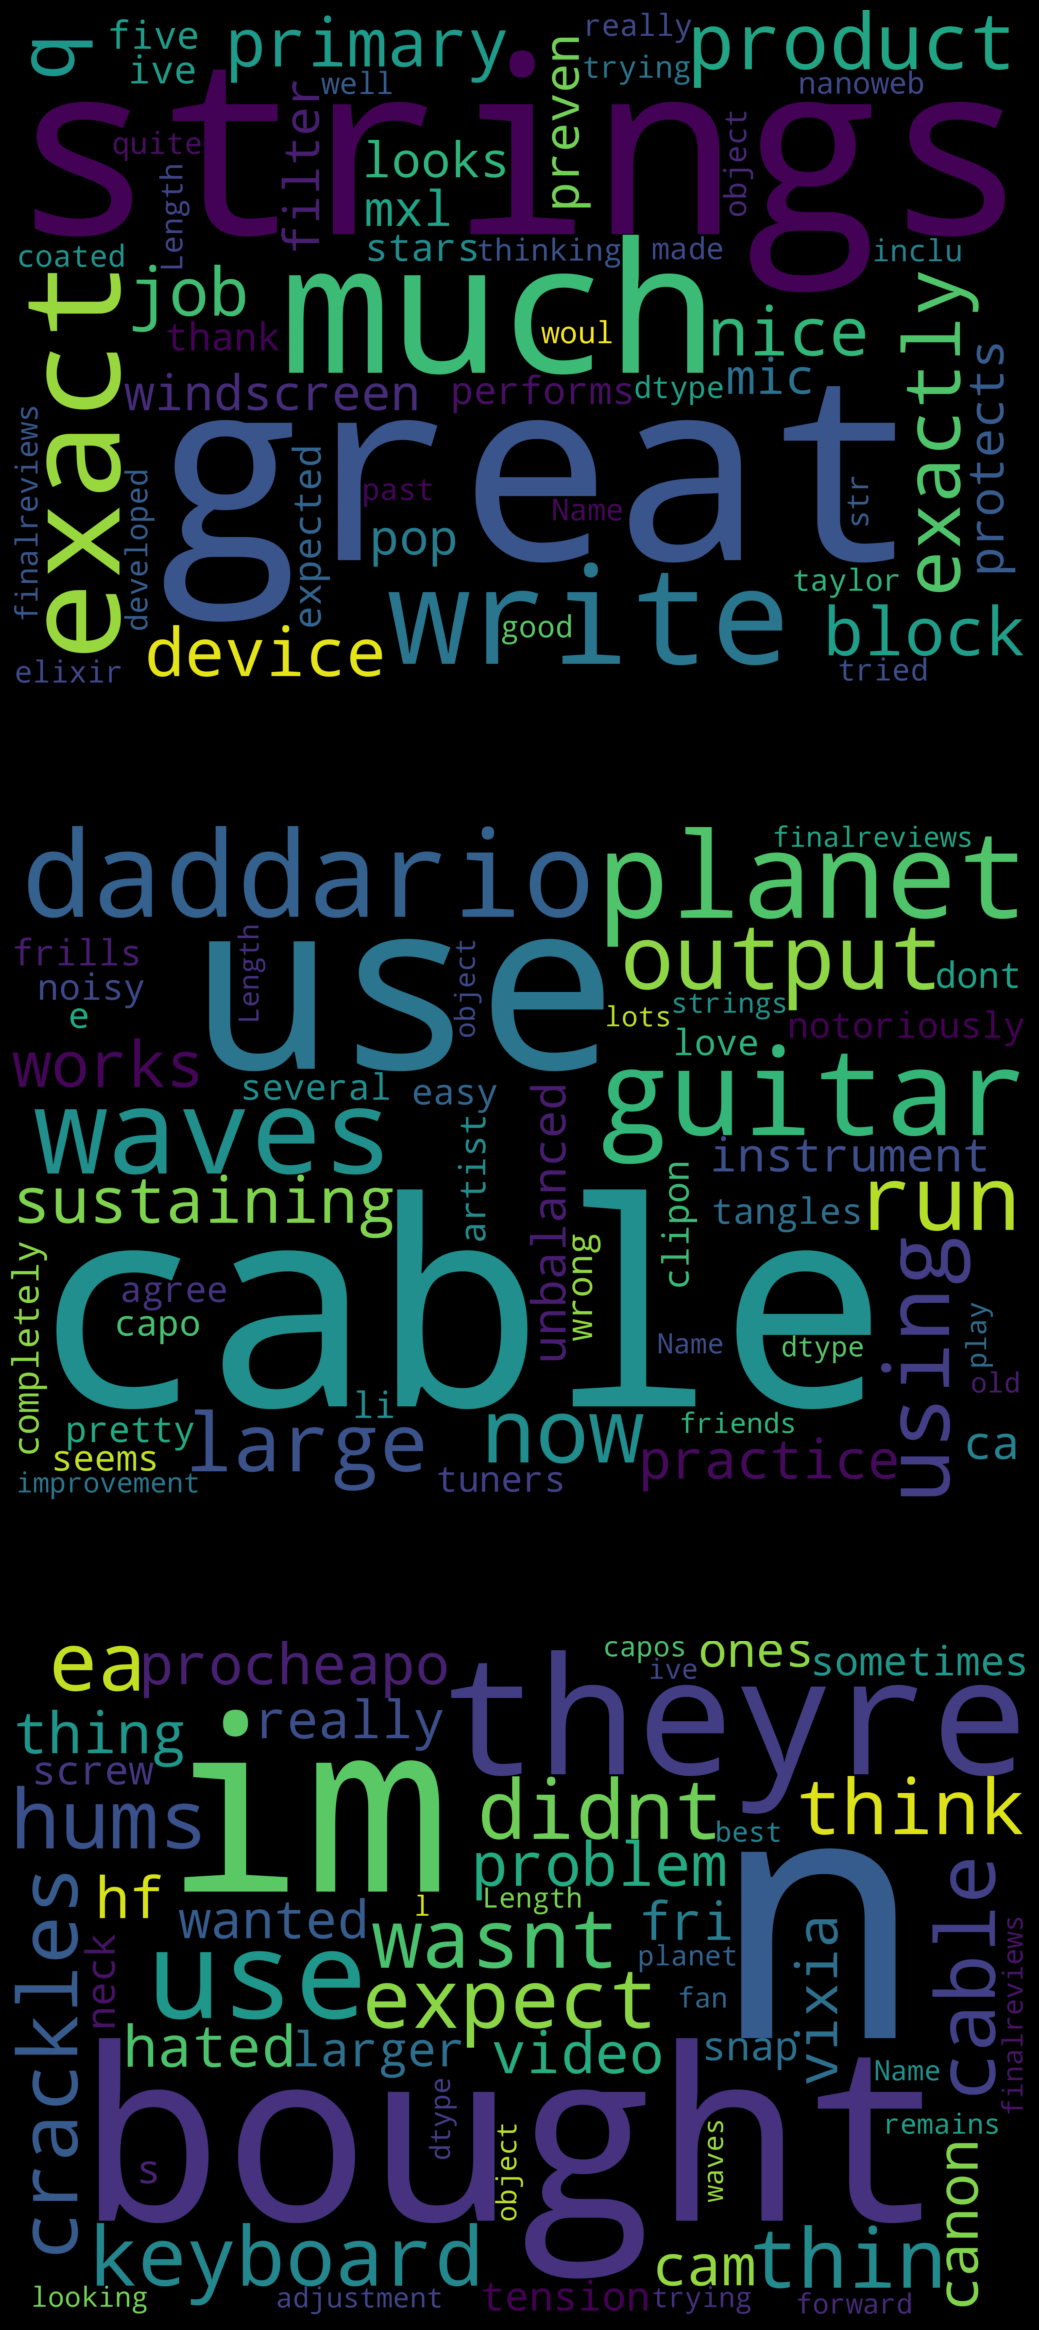

In [8]:
# We do WordClouds for positive, neutral, and negative reviews

fig, axs = plt.subplots(3, 1,  figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
text = review_positive['finalreviews']
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))

axs[0].imshow(wordcloud, interpolation = 'bilinear')
axs[0].axis('off')

text = review_neutral['finalreviews']
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
axs[1].imshow(wordcloud, interpolation = 'bilinear')
axs[1].axis('off')

text = review_negative['finalreviews']
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
axs[2].imshow(wordcloud, interpolation = 'bilinear')
axs[2].axis('off')


In [ ]:
#To run all the selected models, you need to extract only the reviews.
review_text=reviews.copy()
review_text=review_text[['finalreviews']].reset_index(drop=True)
review_text.head()

#A small steamming process is carried out
ps = PorterStemmer()
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_text)):
    review = re.sub('[^a-zA-Z]', ' ', review_text['finalreviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)  

In [ ]:
# Compute a weight to each word which signifies the importance of the word in the document and corpus.
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
X= tfidf_vectorizer.fit_transform(review_text['finalreviews'])

#Getting the sentiment column
y=reviews['sentiment']

In [ ]:
# Run the models
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.8821752260126677
Decision Tree Test Accuracy: 0.8239925519738976
KNN Test Accuracy: 0.8792515341149585
SVC Test Accuracy: 0.8796413027592243
Naive Bayes Test Accuracy: 0.783839074045603


In [ ]:
# We define the LSTM RNN for the unbalanced dataset
# For that, firstly we convert the words into vectors using a Tokenizer and defining the vocabulary size.

tokenizer = Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(reviews['finalreviews'].values)
X = tokenizer.texts_to_sequences(reviews['finalreviews'])
# We need to pad all the texts to make sure all have the same lenght when introduced to the RNN
X = pad_sequences(X, maxlen = 400)
# We one hot encode the target variable. 0 for negative, 1 for neutral and 2 for positive
y=label_binarize(reviews['sentiment'], classes=['negative', 'neutral','positive'])

# We split into train/test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 42)

In [ ]:
# We build the RNN with the unbalanced dataset
embed_dim = 128
lstm_out = 196
vocabSize = 5000
model = Sequential()
model.add(Embedding(vocabSize, embed_dim,input_length = 400))
model.add(LSTM(lstm_out))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()
batch_size = 64
num_epochs = 6
# We split into train/validation set before training
X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]
model.fit(X_train2, y_train2,validation_data = (X_valid,y_valid),epochs = num_epochs, batch_size=batch_size)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 400, 128)          640000    
                                                                 
 lstm_2 (LSTM)               (None, 196)               254800    
                                                                 
 dense_2 (Dense)             (None, 3)                 591       
                                                                 
Total params: 895,391
Trainable params: 895,391
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
136/136 [==============================] - 28s 188ms/step - loss: 0.2785 - accuracy: 0.8750 - val_loss: 0.1984 - val_accuracy: 0.8906
Epoch 2/6
136/136 [==============================] - 18s 135ms/step - loss: 0.1850 - accuracy: 0.8861 - val_loss: 0.1585 - val_accuracy: 0.8906
Epoch 3/6
136/136 [=====

49/49 [==============================] - 1s 11ms/step
Testing Accuracy: 87.53%
Testing loss: 0.24


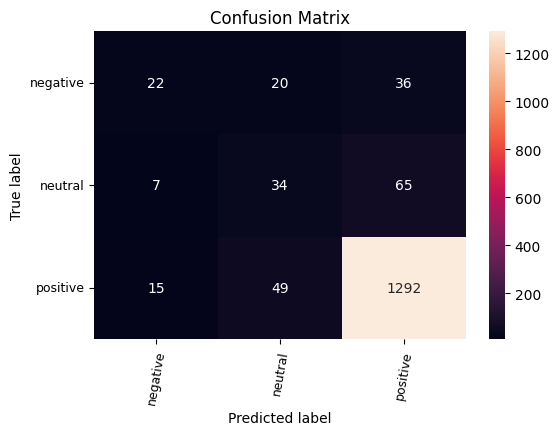

49/49 [==============================] - 0s 8ms/step


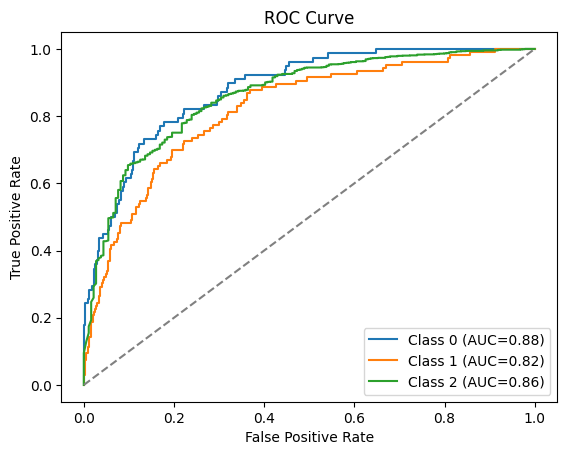

Classification Report:
               precision    recall  f1-score   support

    negative       0.54      0.27      0.36        78
     neutral       0.35      0.32      0.33       106
    positive       0.93      0.95      0.94      1356

   micro avg       0.88      0.87      0.88      1540
   macro avg       0.60      0.51      0.54      1540
weighted avg       0.87      0.87      0.87      1540
 samples avg       0.87      0.87      0.87      1540



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# We print the confusion matrix and the testing accuracy and loss for the unbalanced dataset

y_pred = model.predict(X_test).argmax(axis=-1)
y_true = y_test.argmax(axis=-1)

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(6, 4))
conf=sns.heatmap(cm, annot=True, fmt='d')
conf.set_xticklabels(['negative', 'neutral','positive'])
conf.set_yticklabels(['negative', 'neutral','positive'])

# We print the final accuracy and loss for the test set.
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Testing loss: {:.2f}".format(test_loss))

# Customize the plot,1,1
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.xticks(rotation=80)
plt.yticks(rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# We show the ROC curve and the AUC

y_pred_proba = model.predict(X_test)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC={roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

y_pred = (y_pred_proba > 0.5).astype(int)
print("Classification Report:\n",classification_report(y_test, y_pred,target_names=['negative', 'neutral','positive']))

In [ ]:
# We define the LSTM RNN and we balance the dataset using SMOTE 
# For that, firstly we convert the words into vectors using a Tokenizer and defining the vocabulary size.

tokenizer = Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(reviews['finalreviews'].values)
X = tokenizer.texts_to_sequences(reviews['finalreviews'])
# We need to pad all the texts to make sure all have the same lenght when introduced to the RNN
X = pad_sequences(X, maxlen = 400)
# We one hot encode the target variable. 0 for negative, 1 for neutral and 2 for positive
y=label_binarize(reviews['sentiment'], classes=['negative', 'neutral','positive'])
#print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

#print(f'Resampled dataset shape {Counter(y)}')
# We split into train/test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 42)

In [ ]:
# We build the RNN with the balanced dataset
embed_dim = 128
lstm_out = 196
vocabSize = 5000
model = Sequential()
model.add(Embedding(vocabSize, embed_dim,input_length = 400))
model.add(LSTM(lstm_out))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()
batch_size = 64
num_epochs = 6
# We split into train/validation set before training
X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]
model.fit(X_train2, y_train2,validation_data = (X_valid,y_valid),epochs = num_epochs, batch_size=batch_size)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 400, 128)          640000    
                                                                 
 lstm_6 (LSTM)               (None, 196)               254800    
                                                                 
 dense_6 (Dense)             (None, 3)                 591       
                                                                 
Total params: 895,391
Trainable params: 895,391
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
359/359 [==============================] - 54s 139ms/step - loss: 0.4908 - accuracy: 0.5799 - val_loss: 0.4657 - val_accuracy: 0.6094
Epoch 2/6
359/359 [==============================] - 23s 65ms/step - loss: 0.4060 - accuracy: 0.6722 - val_loss: 0.4433 - val_accuracy: 0.6719
Epoch 3/6
359/359 [======

127/127 [==============================] - 1s 9ms/step
Testing Accuracy: 66.26%
Testing loss: 0.48


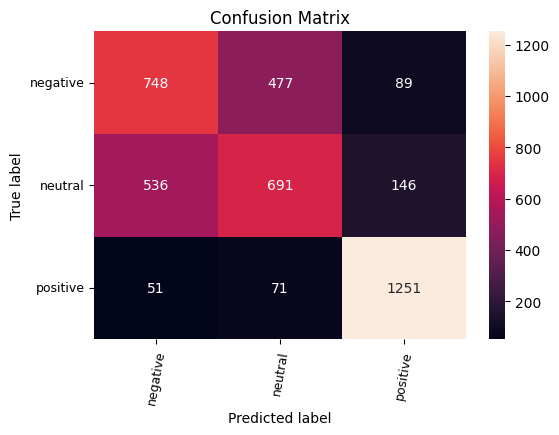

127/127 [==============================] - 1s 8ms/step


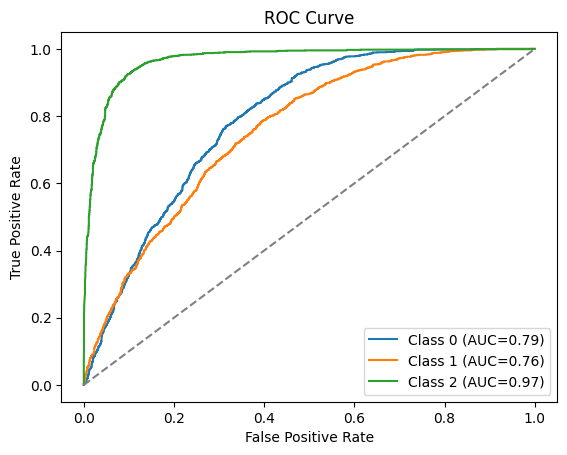

Classification Report:
               precision    recall  f1-score   support

    negative       0.57      0.57      0.57      1314
     neutral       0.56      0.49      0.53      1373
    positive       0.84      0.91      0.87      1373

   micro avg       0.67      0.66      0.66      4060
   macro avg       0.66      0.66      0.66      4060
weighted avg       0.66      0.66      0.66      4060
 samples avg       0.66      0.66      0.66      4060



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# We print the confusion matrix and the testing accuracy and loss for the balanced dataset

y_pred = model.predict(X_test).argmax(axis=-1)
y_true = y_test.argmax(axis=-1)

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(6, 4))
conf=sns.heatmap(cm, annot=True, fmt='d')
conf.set_xticklabels(['negative', 'neutral','positive'])
conf.set_yticklabels(['negative', 'neutral','positive'])

# We print the final accuracy and loss for the test set.
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Testing loss: {:.2f}".format(test_loss))

# Customize the plot,1,1
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.xticks(rotation=80)
plt.yticks(rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# We show the ROC curve and the AUC

y_pred_proba = model.predict(X_test)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC={roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

y_pred = (y_pred_proba > 0.5).astype(int)
print("Classification Report:\n",classification_report(y_test, y_pred,target_names=['negative', 'neutral','positive']))